In [158]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from operator import itemgetter

In [159]:
"""
箱线图处理异常
"""
def box_outlier_detection(data, col):
    """
    分位数，箱线图 ：异常值通常被定义为小于QL－1.5IQR或大于QU＋1.5IQR的值
    其中QL下四分位数，QU上四分位数，IQR：四分位间距
    :param data:
    :return:
    """

    data2 = data.copy()
    col_dat = data2[col]
    # 计算分位数
    # Q1(25%):下四分位数
    Q1 = np.percentile(col_dat, 25)
    # Q3(75%):上四分位数
    Q3 = np.percentile(col_dat, 75)
    #(IQR)四分位间距
    IQR = Q3 - Q1
    # outlier step
    outlier_step = 1.5 * IQR  # 1.5箱线图尺度
    lower_outlier = Q1 - outlier_step
    higher_outlier = Q3 + outlier_step
    #将异常点数据修改为对应边缘数据
    data2.loc[col_dat < lower_outlier, col] = lower_outlier
    data2.loc[col_dat > higher_outlier, col] = higher_outlier

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(data=data[col], palette="Set1", ax=ax[0])
    sns.boxplot(data=data2[col], palette="Set1", ax=ax[1])
    return data2, lower_outlier, higher_outlier

def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """
    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

"""
决策树分箱
"""
def optimal_binning_boundary(x, y):
    '''
       利用决策树对单变量进行分箱处理
    '''

    boundary = []  # 待return的分箱边界值列表

    clf = DecisionTreeClassifier(criterion='entropy',  # “信息熵”最小化准则划分
                                 max_leaf_nodes=6,  # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold

    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

## 1、加载数据

In [160]:
raw_train = pd.read_csv("./data/used_car_train_20200313.csv", sep=" ")
raw_test = pd.read_csv("./data/used_car_testA_20200313.csv", sep=" ")
raw_train.shape, raw_test.shape

((150000, 31), (50000, 30))

In [161]:
raw_train.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [162]:
raw_test.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

In [163]:
## 2、EDA (task2)

##   3、特征工程 
### 3.1 异常值处理
- 箱线图、局部异常系数、孤立森立
- Box-Cox变换
- 长尾截断

In [164]:
# 1) 箱线图处理
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是!!!
# train = outliers_proc(raw_train, 'power', scale=3) # 异常值进行删除

In [165]:
# train, lower_outlier, higher_outlier  = box_outlier_detection(raw_train, 'power')  # 异常值替换
# # 测试集异常值同样进行替换
# test.loc[test.power < lower_outlier] = lower_outlier
# test.loc[test.power > higher_outlier] = higher_outlier

## 3.2 特征构造
- 构造统计量特征，报告计数、求和、比例、标准差等；
- 时间特征，包括相对时间和绝对时间，节假日，双休日等；
- 地理信息，包括分箱，分布编码等方法；
- 非线性变换，包括 log/ 平方/ 根号等；
- 特征组合，特征交叉；
-  仁者见仁，智者见智。

In [166]:
# 训练集和测试集放到一起，方便构造特征
train = raw_train.copy()
test = raw_test.copy()
train['train'] = 1
test['train'] = 0
data = pd.concat([train, test], ignore_index=True, sort=False)
data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train
count,200000.000000,200000.000000,2.000000e+05,199999.000000,200000.000000,194081.000000,188427.000000,192109.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,99999.500000,68397.435475,2.003411e+07,47.057895,8.053610,1.789820,0.375233,0.224794,119.458315,12.596765,...,0.044947,0.124205,0.058107,0.061997,-0.005214,0.003340,0.000221,-0.000552,-0.000137,0.750000
std,57735.171256,61091.016948,5.365956e+04,49.519455,7.853592,1.760665,0.548118,0.417448,179.183258,3.916919,...,0.051748,0.200065,0.029192,0.035682,3.766298,3.272461,2.517105,1.288388,1.035863,0.433014
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556,0.000000
25%,49999.750000,11170.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.000040,0.062518,0.035266,0.033879,-3.716989,-1.956648,-1.873019,-1.058617,-0.437238,0.750000
50%,99999.500000,51785.500000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.000813,0.095857,0.057024,0.058574,1.621345,-0.357720,-0.134311,-0.036196,0.140615,1.000000
75%,149999.250000,118846.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.102014,0.125288,0.079292,0.087490,2.841749,1.257437,1.773703,0.942401,0.680567,1.000000
max,199999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,...,0.153265,1.404936,0.160791,0.222787,12.357011,18.856218,13.847792,11.147669,8.658418,1.000000


### 3.2.1 时间变量处理 - 时间特征，包括相对时间和绝对时间，节假日，双休日等

In [167]:
# 1) 计算使用时间
# data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data["creatDate"], format='%Y%m%d', errors='coerce')
                     - pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

# 汽车使用时间异常值数量、比例为
error_cnt = data['used_time'].isnull().sum()
print("汽车使用时间异常值数量:%d个, 异常值比例：%.2f%%" % (error_cnt, error_cnt/len(data)*100))
train_error_cnt = data[data.train == 1]['used_time'].isnull().sum()
test_error_cnt = data[data.train == 0]['used_time'].isnull().sum()
print("train-汽车使用时间异常值数量:%d个, 异常值比例：%.2f%%" % (train_error_cnt, train_error_cnt/len(train)*100))
print("test-汽车使用时间异常值数量:%d个, 异常值比例：%.2f%%" % (test_error_cnt, test_error_cnt/len(test)*100))

汽车使用时间异常值数量:15101个, 异常值比例：7.55%
train-汽车使用时间异常值数量:11347个, 异常值比例：7.56%
test-汽车使用时间异常值数量:3754个, 异常值比例：7.51%


In [168]:
# 2) 提取年份、月份、是否为双休日、节假日等 (待做)

### 3.2.2 提取城市信息

In [169]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x: str(x)[:-3])

- [:-3]倒数第三个之前的数，eg: '12345'[:-3]为12
- [::-1]从后往前一个个取数，也就是倒序， 而[::-2]从后往前每隔一个取一个数
eg. '12345'[::-1] 为54321， '12345'[::-2]为531， '12345'[::-3]为52

### 3.2.3 构造统计量特征:报告计数、求和、比例、标准差等

In [170]:
# 计算某品牌的销售统计量
# 这里要以 train 的数据计算统计量
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)  # 品牌销量
    info['brand_price_max'] = kind_data.price.max()  # 品牌价格最大、最小、众数、销售总价（这里可以考虑季度、月份、等销售情况等--之后加入（待做）
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std() # 价格标准差
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)  # 平均价格
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand') # 测试集未被覆盖到的品牌数据为空

这里可能会出现训练集品牌不能完全覆盖测试集品牌的情况，
对于这种情况，相应的统计信息为空，因为实际情况也不能全部覆盖，对于训练不到的赋值为空，或者填充特殊值

In [171]:
data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'used_time', 'city', 'brand_amount',
       'brand_price_max', 'brand_price_median', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average'],
      dtype='object')

### 3.3 数据分箱
无监督分箱
- 等频分箱
- 等距分箱
- 聚类分箱

有监督分箱
- Best - KS 分箱（类似利用基尼指数进行二分类）
- 决策树分箱
- 卡方分箱
- 差熵分箱

数据分筒的好处：
1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化
当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性


In [172]:
train = data[data.train==1]
test = data[data.train==0]

In [173]:
# 1) 等频分箱
# 以power为例
# 训练集分箱
train["power_bin"], bins = pd.qcut(train["power"], 10, retbins=True)
train.groupby(["power_bin"], as_index=True).size()

power_bin
(-0.001, 50.0]      16543
(50.0, 65.0]        13665
(65.0, 80.0]        16477
(80.0, 101.0]       17635
(101.0, 110.0]      12543
(110.0, 125.0]      15295
(125.0, 140.0]      13429
(140.0, 163.0]      15522
(163.0, 197.0]      14305
(197.0, 19312.0]    14586
dtype: int64

In [174]:
# 测试集按同样
test["power_bin"] = pd.cut(test["power"],bins=bins, right=True )
test.groupby(["power_bin"], as_index=True).size()

power_bin
(0.0, 50.0]         1253
(50.0, 65.0]        4649
(65.0, 80.0]        5443
(80.0, 101.0]       5933
(101.0, 110.0]      4304
(110.0, 125.0]      4942
(125.0, 140.0]      4368
(140.0, 163.0]      5305
(163.0, 197.0]      4752
(197.0, 19312.0]    4855
dtype: int64

In [175]:
# 2)等距分箱
train["power_bin"], bins = pd.cut(train["power"], 10, retbins=True)
train.groupby(["power_bin"], as_index=True).size()

power_bin
(-19.312, 1931.2]     149956
(1931.2, 3862.4]          17
(3862.4, 5793.6]           2
(5793.6, 7724.8]           9
(7724.8, 9656.0]           2
(9656.0, 11587.2]          3
(11587.2, 13518.4]         2
(13518.4, 15449.6]         2
(15449.6, 17380.8]         3
(17380.8, 19312.0]         4
dtype: int64

In [176]:
test["power_bin"] = pd.cut(test["power"],bins=bins, right=True )
test.groupby(["power_bin"], as_index=True).size()

power_bin
(-19.312, 1931.2]     49984
(1931.2, 3862.4]          6
(3862.4, 5793.6]          1
(5793.6, 7724.8]          3
(7724.8, 9656.0]          0
(9656.0, 11587.2]         1
(11587.2, 13518.4]        2
(13518.4, 15449.6]        2
(15449.6, 17380.8]        0
(17380.8, 19312.0]        0
dtype: int64

In [177]:
# 3)决策树分箱
bins = optimal_binning_boundary(x=np.array(train["power"]), y=train["price"])
train["power_bin"] = pd.cut(train["power"], bins=bins, right=False, labels=False)
test["power_bin"] = pd.cut(train["power"], bins=bins, right=False, labels=False)

In [178]:
train[['power',"power_bin"]].head()

,power,power_bin
0,60,0
1,0,0
2,163,4
3,193,4
4,68,1


#### pd.cut()参数含义

pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise') 
- x：被切分的类数组（array-like）数据，必须是1维的（不能用DataFrame）；


- bins：bins是被切割后的区间（或者叫“桶”、“箱”、“面元”），有3中形式：一个int型的标量、标量序列（数组）或者pandas.IntervalIndex 。
    一个int型的标量
    当bins为一个int型的标量时，代表将x平分成bins份。x的范围在每侧扩展0.1%，以包括x的最大值和最小值。
    标量序列
     标量序列定义了被分割后每一个bin的区间边缘，此时x没有扩展。
    pandas.IntervalIndex
    定义要使用的精确区间。
    
    
- right：bool型参数，默认为True，表示是否包含区间右部。比如如果bins=[1,2,3]，right=True，则区间为(1,2]，(2,3]；right=False，则区间为(1,2),(2,3)。


- labels：给分割后的bins打标签，比如把年龄x分割成年龄段bins后，可以给年龄段打上诸如青年、中年的标签。labels   的长度必须和划分后的区间长度相等，比如bins=[1,2,3]，划分后有2个区间(1,2]，(2,3]，则labels的长度必须为2。   如果指定labels=False，则返回x中的数据在第几个bin中（从0开始）。


- retbins：bool型的参数，表示是否将分割后的bins返回，当bins为一个int型的标量时比较有用，这样可以得到划分后的区间，默认为False。


- precision：保留区间小数点的位数，默认为3.


- include_lowest：bool型的参数，表示区间的左边是开还是闭的，默认为false，也就是不包含区间左部（闭）。


- duplicates：是否允许重复区间。有两种选择：raise：不允许，drop：允许。

返回值

- out：一个pandas.Categorical, Series或者ndarray类型的值，代表分区后x中的每个值在哪个bin（区间）中，如果指定了labels，则返回对应的label。


- bins：分隔后的区间，当指定retbins为True时返回。

### 3.4 归一化处理

In [179]:
# 利用好了，就可以删掉原始数据了
drop_cols = ['creatDate', 'regDate', 'regionCode', 'seller', 'offerType'] #  删除seller和offerType无效变量
data = data.drop(drop_cols, 1)

In [180]:
print(train.shape)
train.columns

(150000, 42)


Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'used_time', 'city', 'brand_amount',
       'brand_price_max', 'brand_price_median', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average',
       'power_bin'],
      dtype='object')

In [181]:
print(data.shape)
data.columns

(200000, 36)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'price', 'v_0', 'v_1', 'v_2',
       'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'used_time', 'city', 'brand_amount',
       'brand_price_max', 'brand_price_median', 'brand_price_min',
       'brand_price_sum', 'brand_price_std', 'brand_price_average'],
      dtype='object')

 我们可以再构造一份特征给 LR NN 之类的模型用
 之所以分开构造是因为，**不同模型对数据集的要求不同**.
 
 LR 需将分类变量进行编码处理，树模型就可以直接使用了

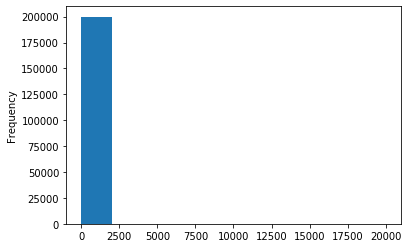

In [182]:
# 查看数据分布：
data['power'].plot.hist()

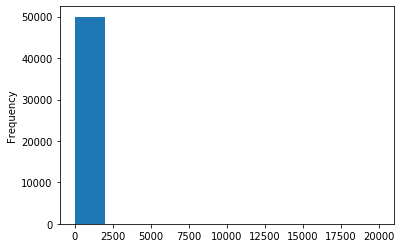

In [183]:
test["power"].plot.hist()

#### 长尾截断

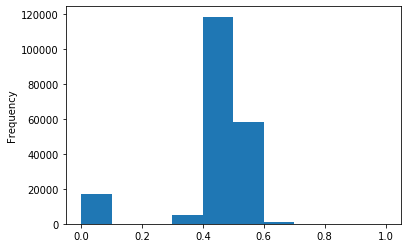

In [184]:
# 我们对其取 log，在做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

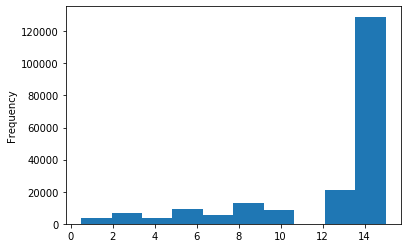

In [185]:
data['kilometer'].plot.hist()

In [186]:
data.kilometer.value_counts()

15.0    129066
12.5     21068
10.0      8565
9.0       7048
8.0       6096
7.0       5492
6.0       4943
5.0       4237
4.0       3616
3.0       3350
2.0       3071
0.5       2456
1.0        992
Name: kilometer, dtype: int64

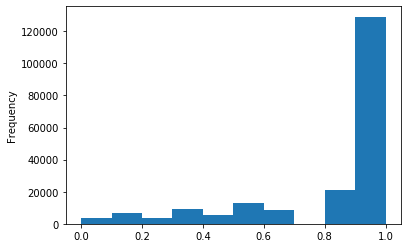

In [187]:
# km 的比较正常，应该是已经做过分桶了
# 直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [188]:
# 除此之外 对刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换，
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = ((data['brand_amount'] - np.min(data['brand_amount'])) / 
                        (np.max(data['brand_amount']) - np.min(data['brand_amount'])))
data['brand_price_average'] = ((data['brand_price_average'] - np.min(data['brand_price_average'])) / 
                               (np.max(data['brand_price_average']) - np.min(data['brand_price_average'])))
data['brand_price_max'] = ((data['brand_price_max'] - np.min(data['brand_price_max'])) / 
                           (np.max(data['brand_price_max']) - np.min(data['brand_price_max'])))
data['brand_price_median'] = ((data['brand_price_median'] - np.min(data['brand_price_median'])) /
                              (np.max(data['brand_price_median']) - np.min(data['brand_price_median'])))
data['brand_price_min'] = ((data['brand_price_min'] - np.min(data['brand_price_min'])) / 
                           (np.max(data['brand_price_min']) - np.min(data['brand_price_min'])))
data['brand_price_std'] = ((data['brand_price_std'] - np.min(data['brand_price_std'])) / 
                           (np.max(data['brand_price_std']) - np.min(data['brand_price_std'])))
data['brand_price_sum'] = ((data['brand_price_sum'] - np.min(data['brand_price_sum'])) / 
                           (np.max(data['brand_price_sum']) - np.min(data['brand_price_sum'])))

### 3.5 类别变量one-hot编码

In [189]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage','city']) #城市也进行编码

In [190]:
print(data.shape)

(200000, 346)


###  3.6 特征筛选
当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。

通常来说，从两个方面考虑来选择特征：
    1. 特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。
    2. 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。
    除方差法外，本文介绍的其他方法均从相关性考虑。

根据特征选择的形式又可以将特征选择方法分为3种：
    1. 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    2. 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    3. 嵌入式（embedding）：也叫集成式，结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，
    常见的有 lasso 回归；


#### 3.6.1 过滤式

In [191]:
## 1）相关系数法-自变量间的相关系数
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

In [192]:
correlation

,power,kilometer,brand_amount,brand_price_average,brand_price_max,brand_price_median
power,1.000000,-0.029441,0.016561,0.184238,0.167575,0.177547
kilometer,-0.029441,1.000000,0.100431,-0.011524,0.088513,-0.026889
brand_amount,0.016561,0.100431,1.000000,0.041590,0.318626,-0.039526
brand_price_average,0.184238,-0.011524,0.041590,1.000000,0.646068,0.984067
brand_price_max,0.167575,0.088513,0.318626,0.646068,1.000000,0.556785
brand_price_median,0.177547,-0.026889,-0.039526,0.984067,0.556785,1.000000


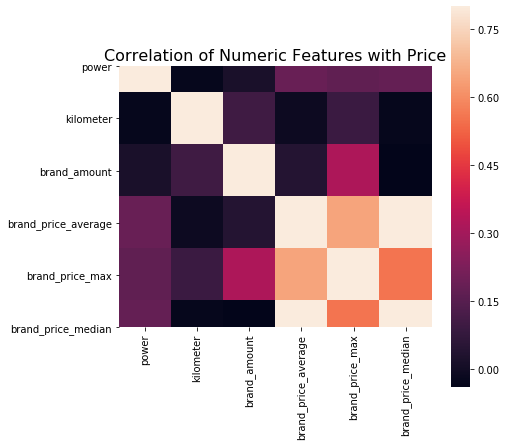

In [136]:
f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [193]:
# 2) 相关系数法 （自变量和因变量的显著性检验，数据类型为定量型数据)
def filter_pearsonr(data, target, topK=2):
    from numpy import var, cov
    from sklearn.feature_selection import SelectKBest
    from scipy.stats import pearsonr#返回值 r, p-value ：r是相关系数，取值-1~1. p-value表示线性相关程度 p-value越小，表示相关程度越显著。

    # 选择K个最好的特征，返回选择特征后的数据
    # 第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
    # 参数k为选择的特征个数

    pearsonr_xy = [np.cov(data[:, i], target)[0,1]/(np.std(data[:, i])*np.std(target)) for i in range(data.shape[1])]
    print('特征的皮尔逊相关系数为：')
    print(pearsonr_xy)
    selectK = SelectKBest(lambda X, Y: tuple(map(tuple, np.array(list(map(lambda x: pearsonr(x, Y), X.T))).T)), k=topK).\
        fit_transform(data, target)
    return selectK

# 3）方差法
def filter_var(data, dat_threshold):
    """
    使用方差选择法，先要计算各个特征的方差，然后根据阈值，选择方差大于阈值的特征
    适用范围：特征取值连续，有监督，分类和回归
    """

    from sklearn.feature_selection import VarianceThreshold

    # 方差选择法，返回值为特征选择后的数据
    # 参数threshold为方差的阈值
    data_var = [np.var(data[i]) for i in range(data.shape[1])]
    print('特征方差：', data_var)
    return VarianceThreshold(threshold=dat_threshold).fit_transform(data)

# 3）卡方独立性检验（自变量和因变量的相关性检验：定性自变量和定性因变量的检验）
def filter_chi2(data, target, topK=2):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2

    # 选择K个最好的特征，返回选择特征后的数据
    xy_chi2 = chi2(data, target)
    print('卡方统计量：', xy_chi2[0])
    print('显著性水平p，越小越好：', xy_chi2[1])
    return SelectKBest(chi2, k=topK).fit_transform(data, target)

# 4)  互信息法（经典的互信息也是评价定性自变量对定性因变量的相关性的）
def filter_mi(data, target, topK):
    """
    MutualInformation:简称MI
    互信息法（经典的互信息也是评价定性自变量对定性因变量的相关性的）,互信息越大，相关性越强
    :param data:
    :param target:
    :param topK:
    :return:
    """
    from sklearn.feature_selection import SelectKBest
    from minepy import MINE
    # 由于MINE的设计不是函数式的，定义mic方法将其为函数式的，返回一个二元组，二元组的第2项设置成固定的P值0.5
    def mic(x, y):
        m = MINE()
        m.compute_score(x, y)
        return (m.mic(), 0.5)

    mi_cal = lambda X, Y: tuple(map(tuple, np.array(list(map(lambda x: mic(x, Y), X.T))).T))#计算互信息
    print("互信息结果：", mi_cal(data, target))
    # 选择K个最好的特征，返回特征选择后的数据
    selectK = SelectKBest(mi_cal, k=topK).fit_transform(data, target)
    return selectK


#### 3.6.2 包裹式

In [194]:
# !pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

train = data[data.train==1]
train = train.drop(['train', 'SaleID', 'name'],1)
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = train.drop(['price'], axis=1)
x = x.fillna(0)
y = train['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

('kilometer',
 'v_0',
 'v_3',
 'v_7',
 'used_time',
 'brand_price_max',
 'brand_price_average',
 'model_145.0',
 'model_167.0',
 'gearbox_1.0')

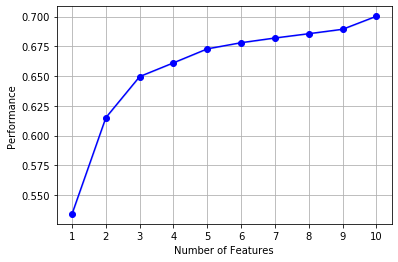

In [195]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

### 3.6.3 嵌入式

In [198]:
###1）基于惩罚项的特征选择法
def embedded_l1_penalty(data, target):
    """
    使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维。
    使用feature_selection库的SelectFromModel类结合带L1惩罚项的逻辑回归模型，来选择特征

    :param data:
    :param target: 
    :return: 
    """
    from sklearn.feature_selection import SelectFromModel
    from sklearn.linear_model import LogisticRegression

    # 带L1惩罚项的逻辑回归作为基模型的特征选择
    lr = LogisticRegression(solver='liblinear',multi_class='auto', penalty="l1", C=0.1)
    features = SelectFromModel(lr).fit_transform(data, target)
    return features

In [ ]:
features = embedded_l1_penalty(x, y)
features

In [197]:
# 2） 基于树模型的特征选择法
def embedded_tree_based(data, target):
    """
    树模型中GBDT,etc,dt 也可用来作为基模型进行特征选择，
    使用feature_selection库的SelectFromModel类结合GBDT模型
    :param data:
    :param target:
    :return:
    """
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.feature_selection import SelectFromModel
    from sklearn import tree
    from matplotlib import pyplot as plt

    ### dt 决策树
    # clf = tree.DecisionTreeClassifier()
    ## etc
    # clf = ExtraTreesClassifier(n_estimators=50)
    ### gbdt
    clf = GradientBoostingClassifier()
    clf = clf.fit(data, target)
    importances = clf.feature_importances_
    print('the Gini importance of the features: ', importances)

    model = SelectFromModel(clf, prefit=True)
    data_new = model.transform(data)

    indices = np.argsort(importances)[::-1]#重要性降序排序
    #特征重要性绘图
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(data.shape[1]), importances[indices],
            color="r", align="center")
    plt.xticks(range(data.shape[1]), indices)
    plt.xlim([-1, data.shape[1]])
    plt.show()
    return data_new
